Epoch [1/5], Loss: 0.0858
Epoch [2/5], Loss: 0.0503
Epoch [3/5], Loss: 0.0382
Epoch [4/5], Loss: 0.0314
Epoch [5/5], Loss: 0.0269


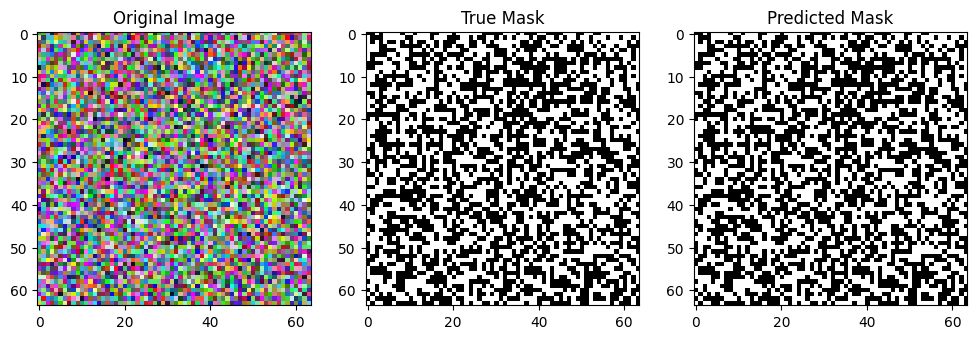

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Создаем случайные данные для обучения
class ColorSegmentationDataset(Dataset):
    def __init__(self, num_samples=1000, image_size=(64, 64)):
        self.num_samples = num_samples
        self.image_size = image_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Создаем случайное изображение
        image = np.random.randint(0, 256, size=(*self.image_size, 3), dtype=np.uint8)

        # Создаем маску сегментации (например, сегментируем по красному цвету)
        mask = (image[..., 0] > 128).astype(np.uint8)

        # Преобразуем в тензоры
        image = transforms.ToTensor()(image)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

# Создаем модель
class ColorSegmentationModel(nn.Module):
    def __init__(self):
        super(ColorSegmentationModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)  # 2 класса: красный и не красный

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Создаем датасет и загрузчик данных
dataset = ColorSegmentationDataset(num_samples=1000)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Инициализируем модель, функцию потерь и оптимизатор
model = ColorSegmentationModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 5
for epoch in range(num_epochs):
    for images, masks in dataloader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Визуализация результатов
def visualize_segmentation(image, mask, predicted_mask):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image.permute(1, 2, 0).numpy())

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(mask.numpy(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap='gray')

    plt.show()

# Тестирование модели на одном изображении
model.eval()
with torch.no_grad():
    test_image, test_mask = dataset[0]
    output = model(test_image.unsqueeze(0))
    predicted_mask = torch.argmax(output, dim=1).squeeze(0).numpy()

    visualize_segmentation(test_image, test_mask, predicted_mask)